In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
from scipy.spatial import distance
from scipy import spatial
from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from pandas import DataFrame, read_csv
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from scipy import spatial
from scipy.spatial import KDTree

In [11]:
file = r'Gaia_plx7_dr2.csv'
df = pd.read_csv(file)
df2 = df.columns.get_values()
df2.tolist()
print('Succesfully Read in the Data')

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (96,122,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unnamed: 0',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source'

In [12]:
# GAIA bands
Gmag = df["phot_g_mean_mag"].values
GBmag = df["phot_bp_mean_mag"].values
GRmag = df["phot_rp_mean_mag"].values
# 2MASS bands
Jmag = df["j_m"].values
Hmag = df["h_m"].values
Kmag = df["ks_m"].values
# SDSS Bands
u_mag = df["u_mag"].values
g_mag = df["g_mag"].values
r_mag = df["r_mag"].values
i_mag = df["i_mag"].values
z_mag = df["z_mag"].values
# Other Important Data
plx = df["parallax"].values

In [13]:
def AbsoluteMagnitudes(plx,GBmag,GRmag,Gmag,Jmag,Hmag,Kmag,umag,gmag,rmag,imag,zmag):
    #Calculates the absolute magnitudes of the stars
    #Read in parallax and apparent magnitude from each band
    
    #Variables Read In
    #plx: column of parallaxes
    #GBmag: column of magnitudes in GB
    #GRmag: column of magnitudes in GR
    #Gmag: column of magnitudes in G
    #Jmag: column of magnitudes in J
    #Kmag: column of magnitudes in K
    #Hmag: column of magnitudes in H
    #umag: column of magnitudes in u
    #gmag: column of magnitudes in g
    #rmag: column of magnitudes in r
    #imag: column of magnitudes in i
    #zmag: column of magnitudes in z
    
    #Variables Returned
    #plx: column of parallaxes
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
        
    
    #create arrays for absolute magnitude
    Dist = np.array([])
    GBmags = np.array([])
    GRmags = np.array([])
    Gmags = np.array([])
    Jmags = np.array([])
    Hmags = np.array([])
    Kmags = np.array([])
    umags = np.array([])
    gmags = np.array([])
    rmags = np.array([])
    imags = np.array([])
    zmags = np.array([])
    
    #calculate the distance of each star in parsecs
    Dist = 1000./plx
    
    #use the distance modulus formula to calculate the absolute magnitude for all the stars
    GBmags = GBmag - 5 * np.log10(Dist) + 5
    GRmags = GRmag - 5 * np.log10(Dist) + 5
    Gmags = Gmag - 5 * np.log10(Dist) + 5
    Jmags = Jmag - 5 * np.log10(Dist) + 5
    Hmags = Hmag - 5 * np.log10(Dist) + 5
    Kmags = Kmag - 5 * np.log10(Dist) + 5
    umags = umag - 5 * np.log10(Dist) + 5
    gmags = gmag - 5 * np.log10(Dist) + 5
    rmags = rmag - 5 * np.log10(Dist) + 5
    imags = imag - 5 * np.log10(Dist) + 5
    zmags = zmag - 5 * np.log10(Dist) + 5
    
    return Dist, GBmags,GRmags,Gmags,Jmags,Hmags,Kmags,umags,gmags,rmags,imags,zmags


In [6]:
def ColorClassification(Gmags,Kmags,colors):    
    #assign the stars into different categories based on G-K
    
    #Variables Read In
    #Gmags: numpy array of absolute magnitudes in G
    #Kmags: numpy array of absolute magnitudes in K
    #colors: list or array of values of G-K in increasing order
    
    #Variables Returned
    #color: numpy array that indicates the category of G-K that each star belongs to
    
    #caclculate the values of G-K for all stars
    G_K = Gmags-Kmags
    
    #create array to hold the G-K color categories 
    color = np.ones(len(G_K))*1000
    
    #compare the value of G-K for each star to the categories and assign a corresponding
    #value for the category in the color array
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color

In [7]:
def CreateTemplates(color,colors,Gmags,Kmags,GB_mags=[999],GR_mags=[999],J_mags=[999],H_mags=[999],umags=[999],gmags=[999],rmags=[999],imags=[999],zmags=[999]):
    #For each category of G-K, a template is created of the absolute magnitudes of the stars and their color indices 
    #calculated with bands of different magnitudes
    # ** Gmags and Kmags is REQUIRED ** 
    #Variables Read In:
    #color: numpy array that indicates the category of G-K that each star belongs to
    #colors: list or array of values of G-K in increasing order
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H 
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
    
    #Variables Returned: 
    #stars: array of the number of stars in each category of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K
    #color_std_err: array of the standard deviation error of thecolor indices at each wavelength for all of the categories of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std_err: array of the standard deviation error of absolute magnitudes in each band for all categores of G-K
    
    if(len(GB_mags) < 2):
        GB_mags = np.ones(len(Gmags))*np.nan
    if(len(GR_mags) < 2):
        GR_mags = np.ones(len(Gmags))*np.nan
    if(len(J_mags) < 2):
        J_mags = np.ones(len(Gmags))*np.nan
    if(len(H_mags) < 2):
        H_mags = np.ones(len(Gmags))*np.nan
    if(len(umags) < 2):
        umags = np.ones(len(Gmags))*np.nan
    if(len(gmags) < 2):
        gmags = np.ones(len(Gmags))*np.nan
    if(len(zmags) < 2):
        zmags = np.ones(len(Gmags))*np.nan
    if(len(imags) < 2):
        imags = np.ones(len(Gmags))*np.nan
    if(len(rmags) < 2):
        rmags = np.ones(len(Gmags))*np.nan
    
    
    #Calculate the values of G-K for each star
    G_K = Gmags-Kmags
    
    #create array to hold the number of stars in each template: 
    stars = np.array([])
    
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_GB_array = np.array([])
        G_GR_array = np.array([])
        G_J_array = np.array([])
        G_H_array = np.array([])
        G_K_array = np.array([])
        G_u_array = np.array([])
        G_g_array = np.array([])
        G_r_array = np.array([])
        G_i_array = np.array([])
        G_z_array = np.array([])
        GB = np.array([])
        GR = np.array([])
        G = np.array([])
        J = np.array([])
        H = np.array([])
        K = np.array([])
        u = np.array([])
        g = np.array([])
        r = np.array([])
        i_m = np.array([])
        z = np.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(Gmags)):
            if (color[i] == c):
                
                G_GB_array = np.append(G_GB_array,Gmags[i]-GB_mags[i])
                G_GR_array = np.append(G_GR_array,Gmags[i]-GR_mags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-J_mags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-H_mags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                G_u_array = np.append(G_u_array,Gmags[i]-umags[i])
                G_g_array = np.append(G_g_array,Gmags[i]-gmags[i])
                G_r_array = np.append(G_r_array,Gmags[i]-rmags[i])
                G_i_array = np.append(G_i_array,Gmags[i]-umags[i])
                G_z_array = np.append(G_z_array,Gmags[i]-zmags[i])
                GB = np.append(GB,GB_mags[i])
                GR = np.append(GR,GR_mags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,J_mags[i])
                H = np.append(H,H_mags[i])
                K = np.append(K,Kmags[i])
                u = np.append(u,umags[i])
                g = np.append(g,umags[i])
                r = np.append(r,rmags[i])
                i_m = np.append(i_m,imags[i])
                z = np.append(z,zmags[i])
                star_count = star_count +1
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.nanmean(G_u_array),np.nanmean(G_g_array), np.nanmean(G_GB_array),\
                     np.nanmean(G_r_array),np.nanmean(G_i_array), np.nanmean(G_GR_array), \
                     np.nanmean(G_z_array),np.nanmean(G_J_array), np.nanmean(G_H_array), \
                     np.nanmean(G_K_array)]
        std_array = [np.nanstd(G_u_array),np.nanstd(G_g_array), np.nanstd(G_GB_array),\
                     np.nanstd(G_r_array),np.nanstd(G_i_array), np.nanstd(G_GR_array), \
                     np.nanstd(G_z_array),np.nanstd(G_J_array), np.nanstd(G_H_array), \
                     np.nanstd(G_K_array)]
        #absolute SED
        mag_array2 = [np.nanmean(u), np.nanmean(g), np.nanmean(GB), \
                      np.nanmean(r), np.nanmean(G), np.nanmean(i), \
                      np.nanmean(GR), np.nanmean(z), np.nanmean(J), \
                      np.nanmean(H), np.nanmean(K)]
        std_array2 = [np.nanstd(u), np.nanstd(g), np.nanstd(GB), \
                      np.nanstd(r), np.nanstd(G), np.nanstd(i_m), \
                      np.nanstd(GR), np.nanstd(z), np.nanstd(J), \
                      np.nanstd(H), np.nanstd(K)]
        #calculate standard deviation error
        val = np.sqrt(len(G_u_array))
        std_array3 = std_array/val
        val2 = np.sqrt(len(u))
        std_array4 = std_array2/val2
        #stack SEDs
        if (c == colors[0]):
            
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            color_std_err = np.array(std_array3)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
            abs_color_std_err = np.array(std_array4)
        else:
            #print(len(color_mags),len(mag_array))
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            color_std_err = np.vstack((color_std_err,std_array3))
            #print('\n',len(abs_color_mags),len(mag_array2))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
            abs_color_std_err = np.vstack((abs_color_std_err,std_array4))
            #A[~np.isnan(A)])
    #print((color_mags))
#     color_mags = color_mags[~np.isnan(color_mags)]
#     #print(len(color_mags))
#     color_std = color_std[~np.isnan(color_std)]
#     color_std_err = color_std_err[~np.isnan(color_std_err)]
#     abs_color_mags = abs_color_mags[~np.isnan(abs_color_mags)]
#     abs_color_std = abs_color_std[~np.isnan(abs_color_std)]
#     abs_color_std_err = abs_color_std_err[~np.isnan(abs_color_std_err)]
#     color_mags = np.reshape(color_mags, (-1, 10))
#     color_std = np.reshape(color_std, (-1, 10))
#     color_std_err = np.reshape(color_std_err, (-1, 10))
#     print(color_mags,'\n',abs_color_mags)
#     abs_color_mags = np.reshape(abs_color_mags, (-1, 11))
#     abs_color_std = np.reshape(abs_color_std, (-1, 11))
#     abs_color_std_err = np.reshape(abs_color_std_err, (-1, 11))
            
    return stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err

In [8]:
def CreatePlots(colors,abs_colors_mags,abs_color_std,color_mags,color_std):
    #create SED and Relative SED plots with the standard deviation as error 
    
    #Variables Read In:
    #colors: list or array of values of G-K in increasing order
    #wvl: list of colors that contain the wavlengths of the filters except for the G filter
    #wvl2: list of colors that contain the wavlengths of the filters
    #stars: array of the number of stars in each category of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K 
    
    #No variables are read out, running the function creates two plots
    
    wvl = [354,420,477,500,623,677,763,913,1250,1650,2170]
    wvl2 = [354,420,477,623,677,763,913,1250,1650,2170]
    new_wvl = []
    new_wvl2 = []
    for i in range(len(abs_color_mags[0])):
        if(str(abs_color_mags[0,i]) != 'nan'):
            new_wvl.append(wvl[i])
            
    for i in range(len(color_mags[0])):
        if(str(color_mags[0,i]) != 'nan'):
            new_wvl2.append(wvl2[i])
    #print(wvl,'\n',wvl2)
#     wvl = wvl[~np.isnan(wvl)]
#     wvl2 = wvl2[~np.isnan(wvl2)]
    
    
    #plot average absolute magnitude in each filter for each value of G-K 
    ax = plt.subplot(111)
    for i in range(len(colors)):
        #color_mags = color_mags[~np.isnan(color_mags)]
        acm = abs_color_mags[i,:]
        acs = abs_color_std[i,:]
        
        acm = acm[~np.isnan(acm)]
        acs = acs[~np.isnan(acs)]
        
        ax.errorbar(new_wvl, acm, yerr = acs, linestyle = '-', marker = 'o',label = str(colors[i]))
       ## ORIGINAL CODE
        #ax.errorbar(wvl, abs_color_mags[i,:], yerr = abs_color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax.set_xlabel('Effective Wavelength (nm)')
    ax.set_ylabel('Average Absolute Magnitude')
    ax.set_title('Spectral Energy Distribution')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    #plot average color index in each filter for each value of G-K
    ax2 = plt.subplot(111)
    for i in range(len(colors)):
        acm = color_mags[i,:]
        acs = color_std[i,:]
        c = str(colors[i])
        acm = acm[~np.isnan(acm)]
        acs = acs[~np.isnan(acs)]
        #print(acm,'\n',new_wvl2)
        ax2.errorbar(new_wvl2, acm, yerr = acs, linestyle = '-', marker = 'o',label = str(colors[i]))
        
       
        #ax2.errorbar(wvl2, color_mags[i,:], yerr = color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax2.set_xlabel('Effective Wavelength (nm)')
    ax2.set_ylabel('Average Color Index')
    ax2.set_title('Spectral Energy Distribution')
    box2 = ax.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return

In [ ]:
# DEFINE HOW MANY TEMPLATES YOU WANT TO PLOT BASED ON G-K COLOR

colors = np.arange(-1,5,0.2) # EDIT THIS TO USE DESIRED NUMBER OF COLORS
color = ColorClassification(Gmag,Kmag,colors)

stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
CreateTemplates(color,colors,Gmag,Kmag,GB_mags=GBmag,GR_mags=GRmag,J_mags=Jmag,H_mags=Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


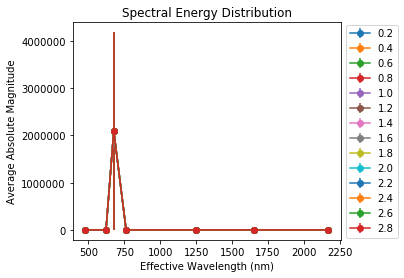

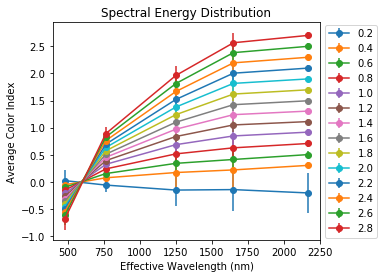

In [10]:
CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

In [188]:
starBands = [Gmag[3],GBmag[3],GRmag[3],Jmag[3],Hmag[3],Kmag[3]]
print(starBands)

new_starBands = []
for i in range(len(starBands)):
    if(i == 0):
        G = starBands[i]
    else:
        G_X = G - starBands[i]
        new_starBands.append(G_X)
print(new_starBands)

[19.193765640258789, 21.362565994262692, 17.763076782226562, 15.64799976348877, 14.982000350952148, 14.767000198364258]
[-2.1688003540039027, 1.4306888580322266, 3.5457658767700195, 4.2117652893066406, 4.4267654418945312]


In [163]:
# ONLY GAIA BANDS AND 2MASS BANDS
def StarFitting(starBands,color_mags,color_std):
    new_starBands = []
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    Chi2_vals = []
    for i in range(len(template_bands)):
        Chi2 = 0
        for j in range(len(new_starBands)):
            Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(template_err[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-1)
        Chi2_vals.append(Chi2)

    
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            best_fit = i
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    print(best_fit)
    return best_fit, new_starBands    

In [189]:
fit, new_starBands = StarFitting(starBands,color_mags,color_std)



new_starBands = []
for i in range(len(starBands)):
    if(i == 0):
        G = starBands[i]
    else:
        G_X = G - starBands[i]
        new_starBands.append(G_X)
# print(new_starBands)

# print('\n\n\n\n\n',color_mags,'\n\n',new_starBands)
#print(fit)

0


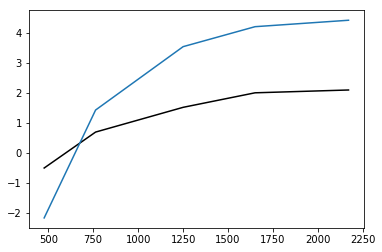

4.42676544189
2.8


In [187]:
wvl2 = [354,420,477,623,677,763,913,1250,1650,2170]
y = color_mags[10,:][~np.isnan(color_mags[10,:])]
new_wvl2 = []
for i in range(len(color_mags[3])):
    if(str(color_mags[2,i]) != 'nan'):
        new_wvl2.append(wvl2[i])
x = new_wvl2

starBands = np.array(starBands)
new_wvl2 = np.array(new_wvl2)
plt.plot(x,y,color='black')
plt.plot(x,new_starBands)
plt.show()


print(Gmag[3]-Kmag[3])
print(colors[13])

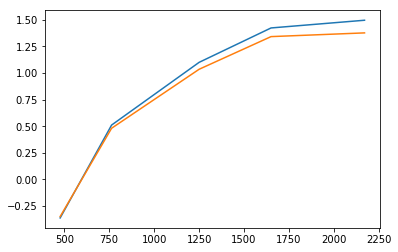

In [63]:
wvl2 = [354,420,477,623,677,763,913,1250,1650,2170]
y = color_mags[7,:][~np.isnan(color_mags[7,:])]
new_wvl2 = []
for i in range(len(color_mags[6])):
    if(str(color_mags[6,i]) != 'nan'):
        new_wvl2.append(wvl2[i])
x = new_wvl2

starBands = np.array(starBands)
new_wvl2 = np.array(new_wvl2)
plt.plot(x,y)
plt.plot(x,new_starBands)
plt.show()

In [165]:
all_starBands = []
for i in range(10000):
    if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan):
        all_starBands.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
all_starBands = np.array(all_starBands)
print(all_starBands[0])

[ 16.30409813  17.6627121   15.15303516  13.65299988  13.1619997
  12.88899994]


In [166]:
star_bin_vals = []
temp_bin_vals = []

for i in range(len(all_starBands)):
    starBands= all_starBands[i]
    #starBands = np.array(starBands)
    fit, new_starBand = StarFitting(starBands,color_mags,color_std)
    temp_bin_vals.append(colors[fit])
    
    diff_vals = []
    for j in range(len(colors)):
        diff = abs(colors[j] - new_starBand[4])
        diff_vals.append(diff)
    
    for j in range(len(diff_vals)):
        if(diff_vals[j] == np.min(diff_vals)):
            star_bin_vals.append(colors[j])
            

13
6
0
0
0
6
13
0


UnboundLocalError: local variable 'best_fit' referenced before assignment

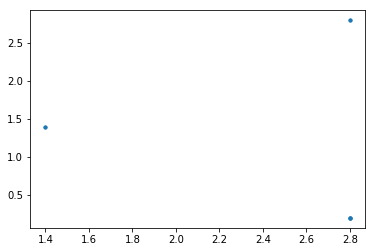

[2.8000000000000003, 1.4000000000000001, 2.8000000000000003, 2.8000000000000003, 2.8000000000000003, 1.4000000000000001, 2.8000000000000003, 2.8000000000000003] 
 [2.8000000000000003, 1.4000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 1.4000000000000001, 2.8000000000000003, 0.20000000000000001]


In [173]:
len(temp_bin_vals)

plt.plot(star_bin_vals,temp_bin_vals,'.')
plt.show()


print(star_bin_vals,'\n',temp_bin_vals)